# PredNet Straighteness

In [1]:
import torch
import torch.nn as nn
from PIL import Image
import numpy as np
import os
from six.moves import cPickle
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import tensorflow as tf
from keras import backend as K
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten

from prednet import PredNet
from prednet_kitti_utils import SequenceGenerator
import math

import sys
# sys.path.insert(0, '../')
sys.path.append('../Henaff_straightening')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

from utils_henaff import *
from fast_curvature import *
from prednet_utils import *
print('imports complete!')

/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/vision/billf/scratch/annekh/miniconda3/envs/tf_19/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

imports complete!


In [2]:
p = 4
prednet_names = ["pretrained_kitti_original","pretrained_kitti_Lall","pretrained_kitti_extrapfinetuned", 'prednet_straight_0','prednet_straight_R3_1800']
prednet_models = {prednet_names[0]:["./model_data_keras2/tensorflow_weights/prednet_kitti_weights.hdf5","./model_data_keras2/prednet_kitti_model.json"],
                prednet_names[1]:["./model_data_keras2/tensorflow_weights/prednet_kitti_weights-Lall.hdf5","./model_data_keras2/prednet_kitti_model.json"],
                prednet_names[2]:["./model_data_keras2/tensorflow_weights/prednet_kitti_weights-extrapfinetuned.hdf5","./model_data_keras2/prednet_kitti_model-extrapfinetuned.json"],
                prednet_names[3]:['./prednet_weights/prednet_weights_lambda.hdf5','./prednet_weights/prednet_model_lambda.json'],
                prednet_names[4]:['./prednet_weights/prednet_weights_R3_1800.hdf5','./prednet_weights/prednet_model_R3_1800.json']}

In [3]:
model = load_prednet_weights(prednet_models[prednet_names[p]][0],
                                  prednet_models[prednet_names[p]][1])
layer_config = model.layers[1].get_config()
data_format = layer_config['data_format']

In [4]:
trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))


Total params: 6,915,964
Trainable params: 6,915,948
Non-trainable params: 16


## KITTI Videos

In [4]:
model_blocks = get_prednet_blocks(model)

R3
R2
R1
R0
prediction


In [5]:
X_test = load_kitti_test(test_path='../../prednet_coxlab/kitti_hkl_py3/X_test.hkl',
                        test_sources='../../prednet_coxlab/kitti_hkl_py3/sources_test.hkl')

In [6]:
if data_format == 'channels_last':
    kitti_outputs = get_prednet_outputs(X_test, model_blocks)
else:
    kitti_outputs = get_prednet_outputs(X_test.transpose((0,1,4,2,3)), model_blocks)


0
torch.Size([83, 9, 16, 20, 192])
1
torch.Size([83, 9, 32, 40, 96])
2
torch.Size([83, 9, 64, 80, 48])
3
torch.Size([83, 9, 128, 160, 3])
4
torch.Size([83, 9, 128, 160, 3])


In [7]:
curve_results = {'kitti_test':[None, None]}

curve_results['kitti_test'][0], curve_results['kitti_test'][1] = collect_model_curves(kitti_outputs, 
                                           torch.from_numpy(X_test[:,:,:,:,:]), use_outputs=True)

In [8]:
mean_curve = curve_results['kitti_test'][0].mean(0)

ste_curve = curve_results['kitti_test'][0].std(0)/X_test.shape[0]**0.5

curve_plot = mean_curve - mean_curve[0].repeat(mean_curve.size(0))

prednet_straight_R3_1800


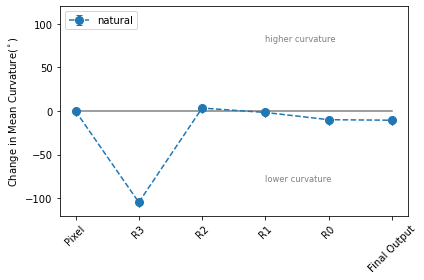

In [9]:
xlabels = ['Pixel', 'R3', 'R2','R1', 'R0', 'Final Output']
all_curves = {'layer_names':xlabels,'natural_curves':mean_curve, 'contrast_curves':torch.ones_like(mean_curve)*float('NaN'),'artificial_curves':torch.ones_like(mean_curve)*float('NaN'),
              'natural_ste':ste_curve, 'contrast_ste':torch.ones_like(ste_curve)*float('NaN'),'artificial_ste':torch.ones_like(ste_curve)*float('NaN')}
output_dir = './prednet_kitti_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(6,4))
plt.errorbar(xlabels, curve_plot, yerr=ste_curve, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-120, 120])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-3], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-3], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = prednet_names[p]
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
print(name)
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)

## Henaff Videos

In [5]:
if data_format == 'channels_last':
    model_blocks = get_prednet_blocks(model,time_steps=11,input_shape=(11,224,224,3))
else:
    model_blocks = get_prednet_blocks(model,time_steps=11,input_shape=(11,3,224,224))

R3
R2
R1
R0
prediction


In [6]:
vid = load_all_henaff_videos_corrected(img_size=224,rgb=True,imagenet=False)
if data_format == 'channels_last':
    natural = vid['natural'].permute((0,1,3,4,2))
    contrast = vid['contrast'].permute((0,1,3,4,2))
    artificial = vid['artificial'].permute((0,1,3,4,2))
    print(natural.shape)
else:
    natural = vid['natural']
    contrast = vid['contrast']
    artificial = vid['artificial']
    print(natural.shape)

videos = [natural.numpy(), contrast.numpy(), artificial.numpy()]
all_videos = vid

natural
contrast


../Henaff_straightening/utilities.py:73: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729004493/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  x[i].copy_( imgA ).mul_( 1-t ).add_( t, imgB )


artificial
torch.Size([12, 11, 224, 224, 3])


In [7]:
natural_outputs = get_prednet_outputs(videos[0], model_blocks)
contrast_outputs = get_prednet_outputs(videos[1], model_blocks)
artificial_outputs = get_prednet_outputs(videos[2], model_blocks)

0
torch.Size([12, 10, 28, 28, 192])
1
torch.Size([12, 10, 56, 56, 96])
2
torch.Size([12, 10, 112, 112, 48])
3
torch.Size([12, 10, 224, 224, 3])
4
torch.Size([12, 10, 224, 224, 3])
0
torch.Size([10, 10, 28, 28, 192])
1
torch.Size([10, 10, 56, 56, 96])
2
torch.Size([10, 10, 112, 112, 48])
3
torch.Size([10, 10, 224, 224, 3])
4
torch.Size([10, 10, 224, 224, 3])
0
torch.Size([12, 10, 28, 28, 192])
1
torch.Size([12, 10, 56, 56, 96])
2
torch.Size([12, 10, 112, 112, 48])
3
torch.Size([12, 10, 224, 224, 3])
4
torch.Size([12, 10, 224, 224, 3])


In [8]:
curve_results = {}
curve_results['Henaff_natural'] = [None, None]

curve_results['Henaff_natural'][0], curve_results['Henaff_natural'][1] = collect_model_curves(natural_outputs, 
                                           torch.from_numpy(videos[0]), 
                                            use_outputs=True)

curve_results['Henaff_contrast'] = [None, None]

curve_results['Henaff_contrast'][0], curve_results['Henaff_contrast'][1] = collect_model_curves(contrast_outputs, 
                                           torch.from_numpy(videos[1]), 
                                            use_outputs=True)

curve_results['Henaff_artificial'] = [None, None]

curve_results['Henaff_artificial'][0], curve_results['Henaff_artificial'][1] = collect_model_curves(artificial_outputs, 
                                           torch.from_numpy(videos[2]), 
                                            use_outputs=True)

In [9]:
mean_natural = curve_results['Henaff_natural'][0].mean(0)
mean_contrast = curve_results['Henaff_contrast'][0].mean(0)
mean_artificial = curve_results['Henaff_artificial'][0].mean(0)

# ste_natural = curve_results['Henaff_natural'][0].std(0)
# ste_contrast = curve_results['Henaff_contrast'][0].std(0)
# ste_artificial = curve_results['Henaff_artificial'][0].std(0)

print(curve_results['Henaff_natural'][0].shape[0])

ste_natural = curve_results['Henaff_natural'][0].std(0)/curve_results['Henaff_natural'][0].shape[0]**0.5
ste_contrast = curve_results['Henaff_contrast'][0].std(0)/curve_results['Henaff_contrast'][0].shape[0]**0.5
ste_artificial = curve_results['Henaff_artificial'][0].std(0)/curve_results['Henaff_artificial'][0].shape[0]**0.5

natural_plot = mean_natural - mean_natural[0].repeat(mean_natural.size(0))
contrast_plot = mean_contrast - mean_contrast[0].repeat(mean_contrast.size(0))
artificial_plot = mean_artificial - mean_artificial[0].repeat(mean_artificial.size(0))

12


prednet_straight_R3_1800


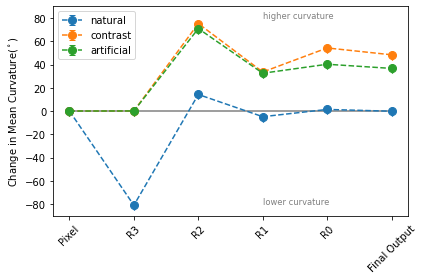

In [10]:
xlabels = ['Pixel', 'R3', 'R2','R1', 'R0', 'Final Output']
all_curves = {'layer_names':xlabels,'natural_curves':mean_natural, 'contrast_curves':mean_contrast,'artificial_curves':mean_artificial,
              'natural_ste':ste_natural, 'contrast_ste':ste_contrast,'artificial_ste':ste_artificial}
output_dir = './prednet_curves'
os.makedirs(output_dir,exist_ok=True)

plt.figure(figsize=(6,4))
plt.errorbar(xlabels, natural_plot, yerr=ste_natural, marker = 'o', linestyle='--',markersize=8,label='natural',uplims=True, lolims=True)
plt.errorbar(xlabels, contrast_plot, yerr=ste_contrast, marker = 'o', linestyle='--',markersize=8,label='contrast',uplims=True, lolims=True)
plt.errorbar(xlabels, artificial_plot, yerr=ste_artificial, marker = 'o', linestyle='--',markersize=8,label='artificial',uplims=True, lolims=True)

plt.plot([xlabels[0], xlabels[-1]],[0,0], '-', color='gray')
plt.ylim([-90, 90])
plt.ylabel('Change in Mean Curvature($^\circ$)')
plt.text(xlabels[-3], -80,'lower curvature', color='gray',fontsize='small')
plt.text(xlabels[-3], 80,'higher curvature', color='gray',fontsize='small')
plt.legend(loc='upper left')
plt.xticks(rotation=45)
# plt.title('Change in Curvature Across Alexnet Blocks (with PCA)', fontsize=12)
plt.tight_layout()
name = prednet_names[p]
save_name = os.path.join(output_dir,f'{name}_curve_change.png')
print(name)
plt.savefig(save_name,dpi=300)
write_model_csv(output_dir, name, all_curves)